In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2023-11-19 20:50:29.190814: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-19 20:50:29.228061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 20:50:29.228093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 20:50:29.228991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 20:50:29.234663: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-19 20:50:29.235304: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
rd_state = 666

In [3]:
from sklearn.model_selection import train_test_split

all_data = pd.read_csv("train.csv")
challenge_input = pd.read_csv("test.csv")
challenge_labels = challenge_input['label']
challenge_input = challenge_input.drop('label', axis=1)

# Normalize pixel values in [0,1]
all_data.loc[:, all_data.columns != 'label'] = all_data.loc[:, all_data.columns != 'label']/255
challenge_input = challenge_input/255

all_input = all_data.drop('label', axis=1)
all_labels = all_data['label'].copy()

# Extract a validation set
train_input, validate_input, train_labels, validate_labels = train_test_split(all_input, all_labels, test_size=0.05, random_state=rd_state)

# Extract a testing set
train_input, test_input, train_labels, test_labels = train_test_split(train_input, train_labels, test_size=0.10, random_state=rd_state)

train_both = train_input.copy()
train_both['label'] = train_labels

# Sanity check
print("All data:  %s" % (all_data.shape,))
print("All input: %s" % (all_input.shape,))
print("Training:  %s" % (train_input.shape,))
print("Test set:  %s" % (test_input.shape,))
print("Validate:  %s" % (validate_input.shape,))
print("Challenge: %s" % (challenge_input.shape,))

All data:  (60000, 785)
All input: (60000, 784)
Training:  (51300, 784)
Test set:  (5700, 784)
Validate:  (3000, 784)
Challenge: (10000, 784)


In [4]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

def label_str(label):
    return labels[label]

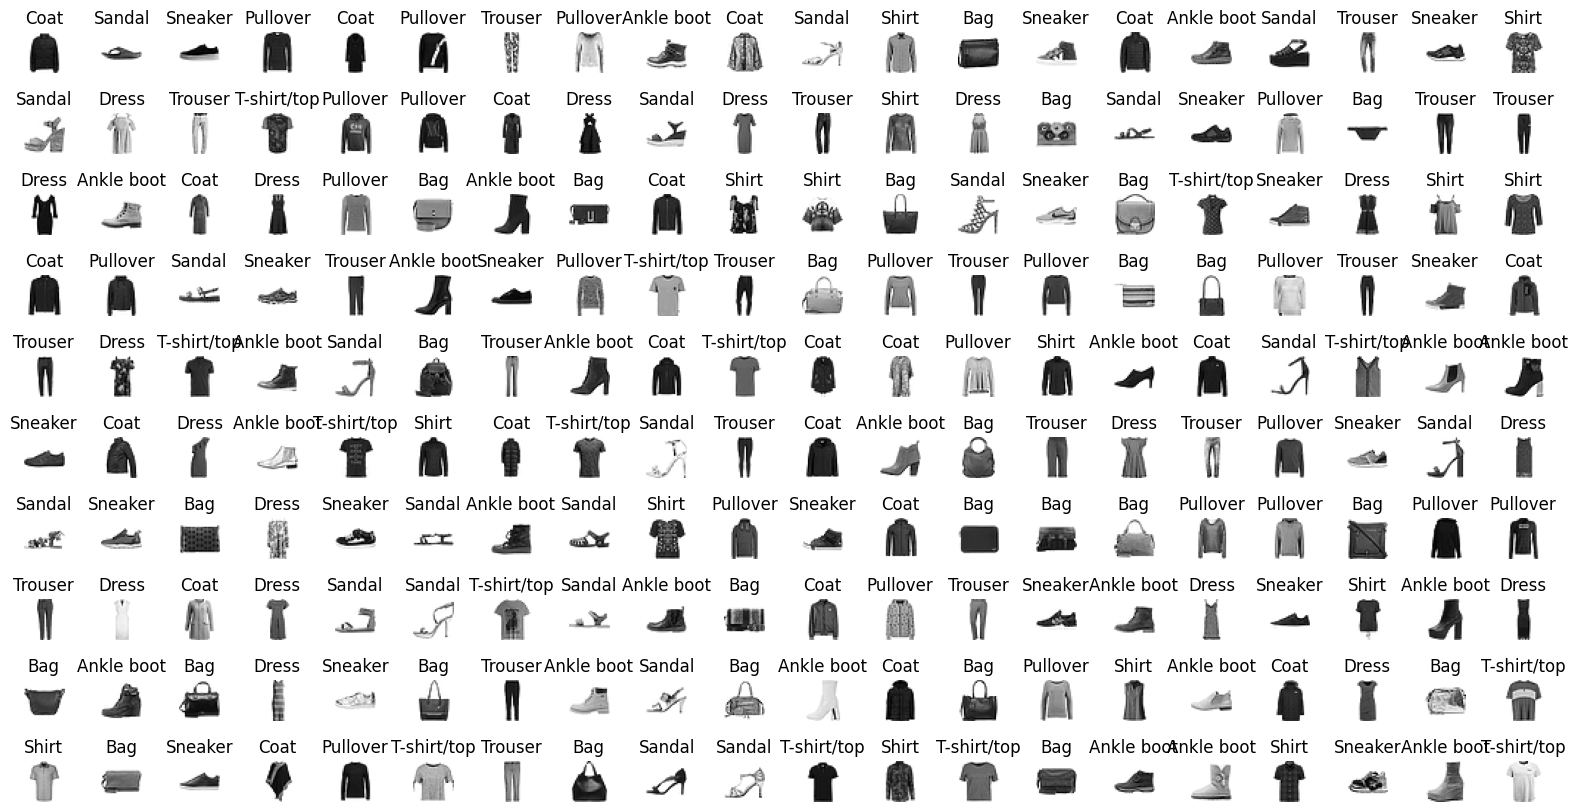

In [5]:
def show_items(inp, X, Y, label=None, labels=None, true_labels=None):
    fX = 20
    fY = int(fX*Y/X)

    figure, axis = plt.subplots(max(Y, 2), max(X, 2), figsize=(fX,fY))
    if label is not None:
        if not isinstance(label, str):
            label = label_str(label)
        figure.suptitle(label, y=0.9)
    plt.subplots_adjust(wspace=0.1, hspace=1)
    for x in range(X):
        for y in range(Y):
            axis[y, x].imshow(inp.iloc[y*X+x].to_numpy().reshape(28, 28), cmap='gray_r')
            axis[y, x].axis('off')
            if labels is not None:
                if true_labels is not None:
                    axis[y, x].set_title(label_str(labels[y*X+x]) + " != " + label_str(true_labels[y*X+x]))
                else:
                    axis[y, x].set_title(label_str(labels[y*X+x]))

# Let's peek at some random digits
show_items(train_input, 20, 10, labels=train_labels.to_numpy())

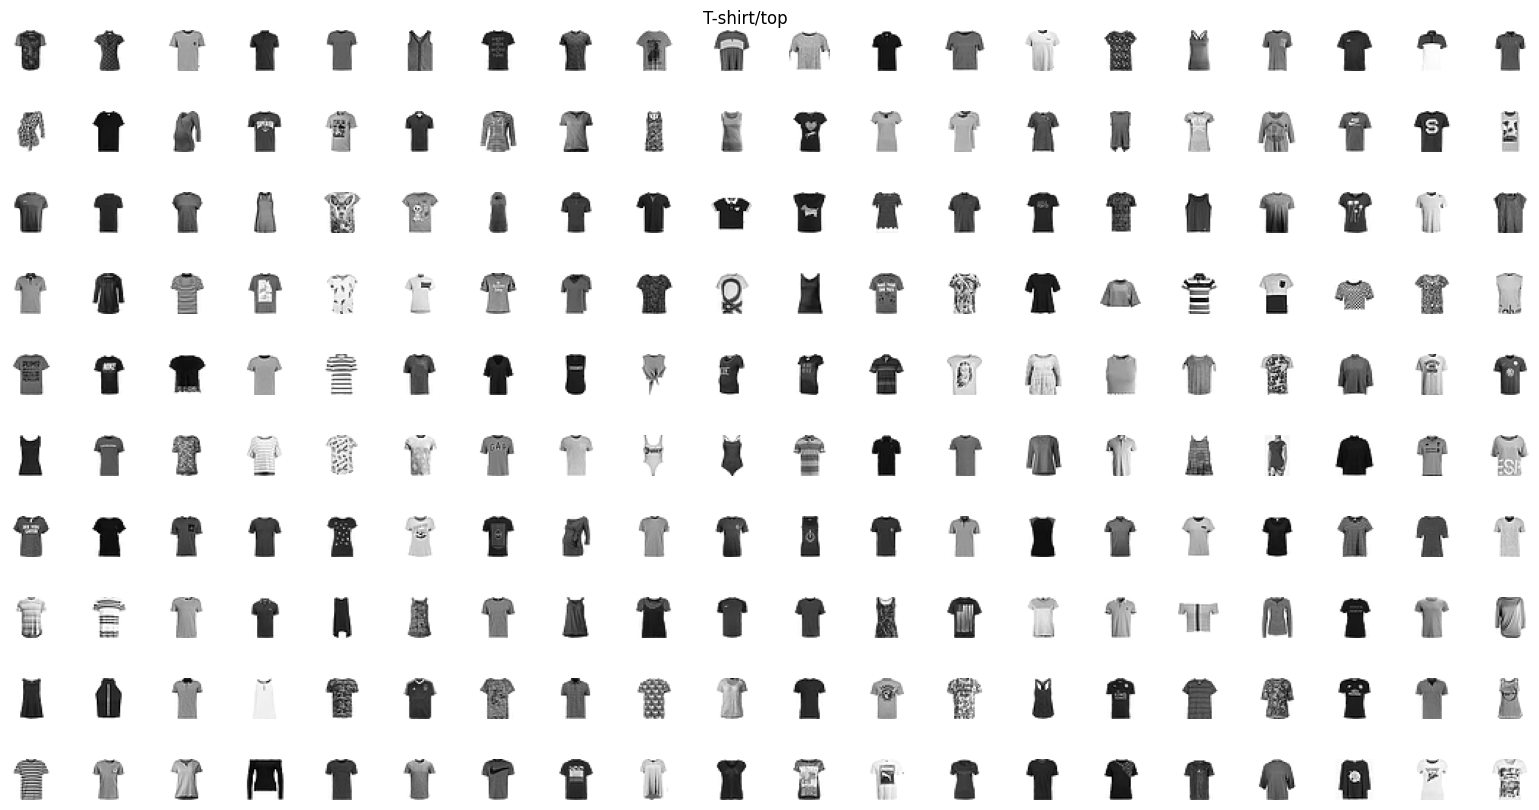

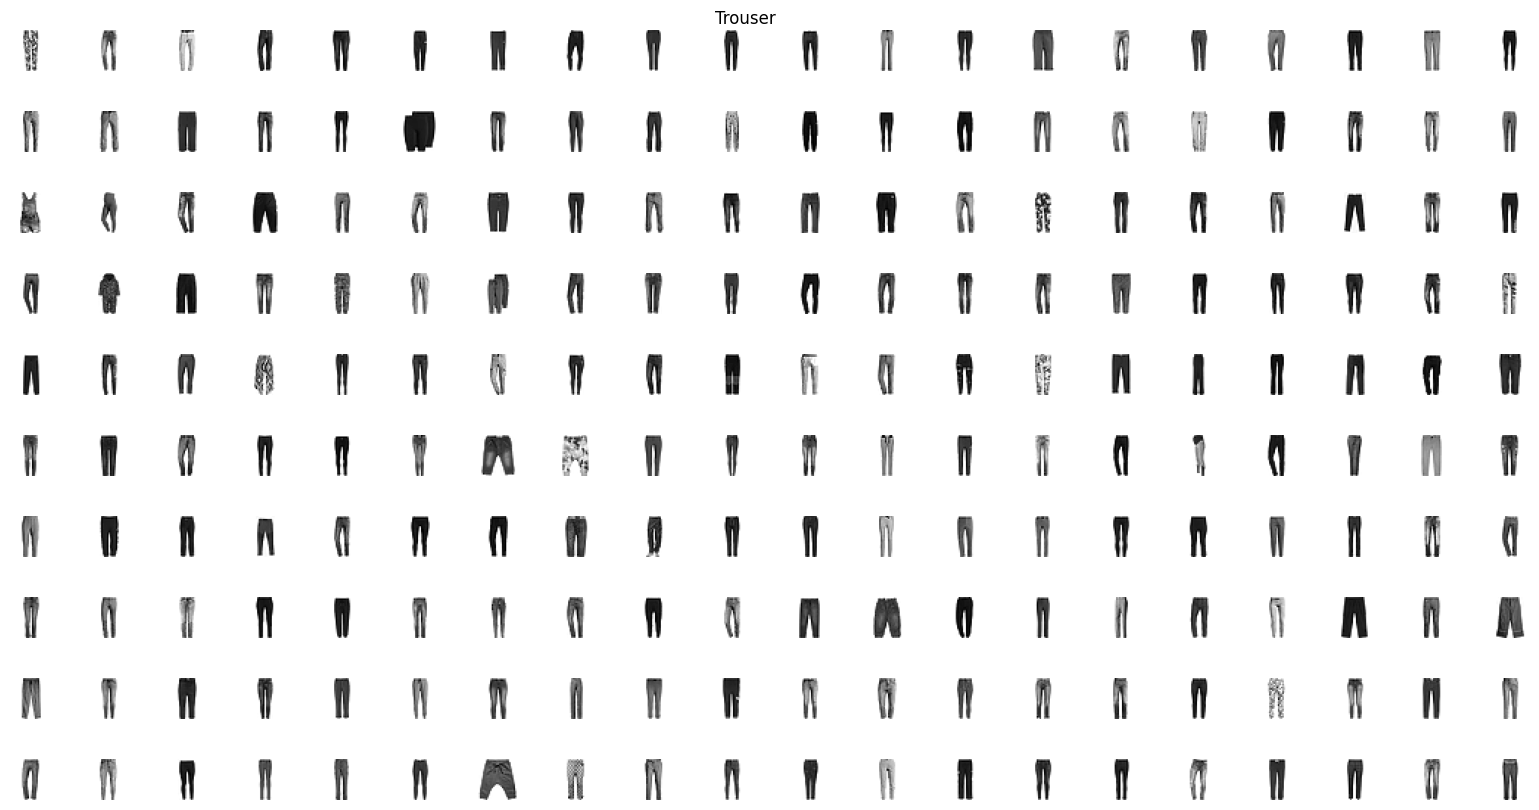

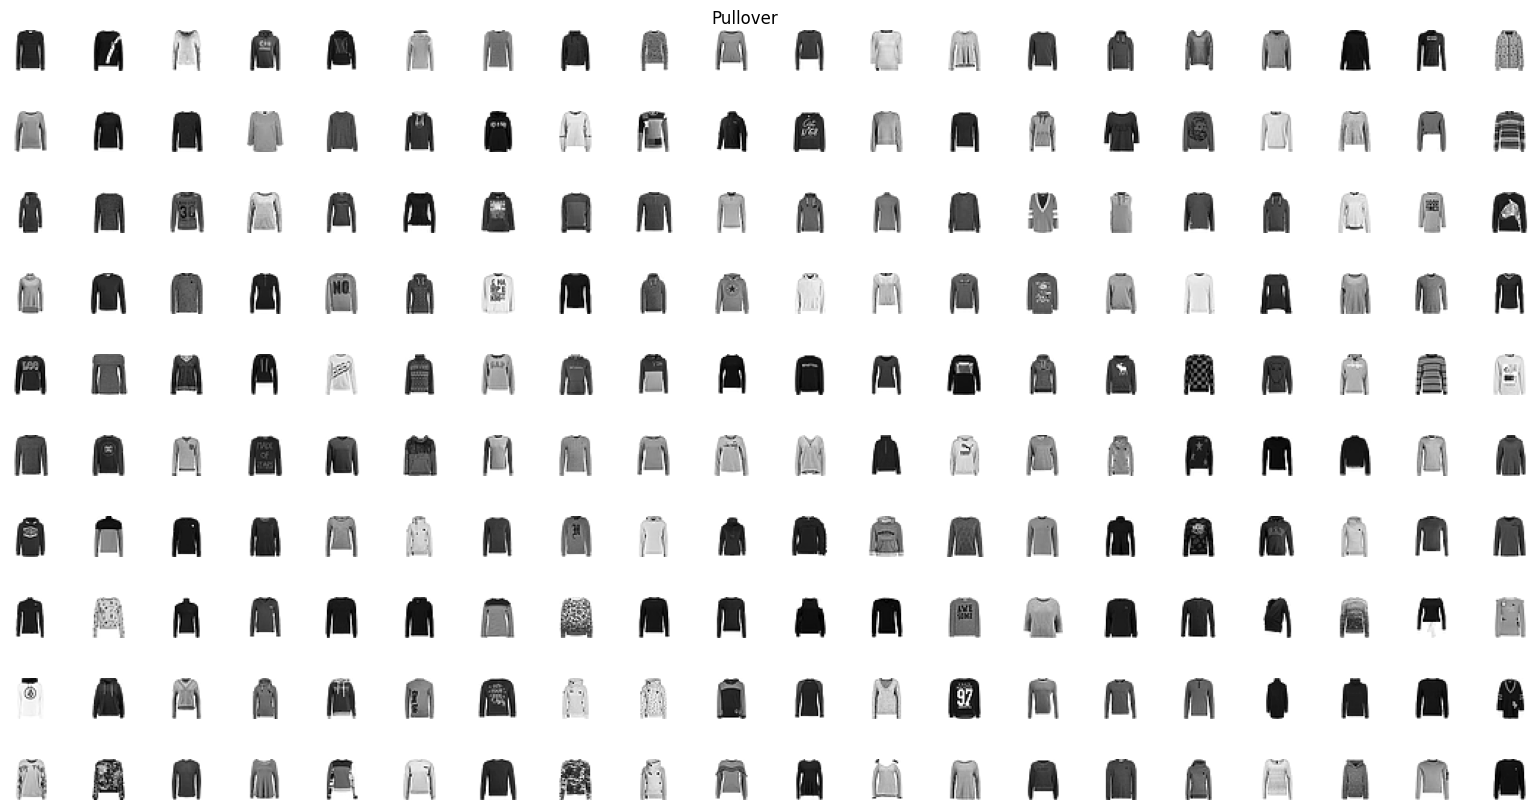

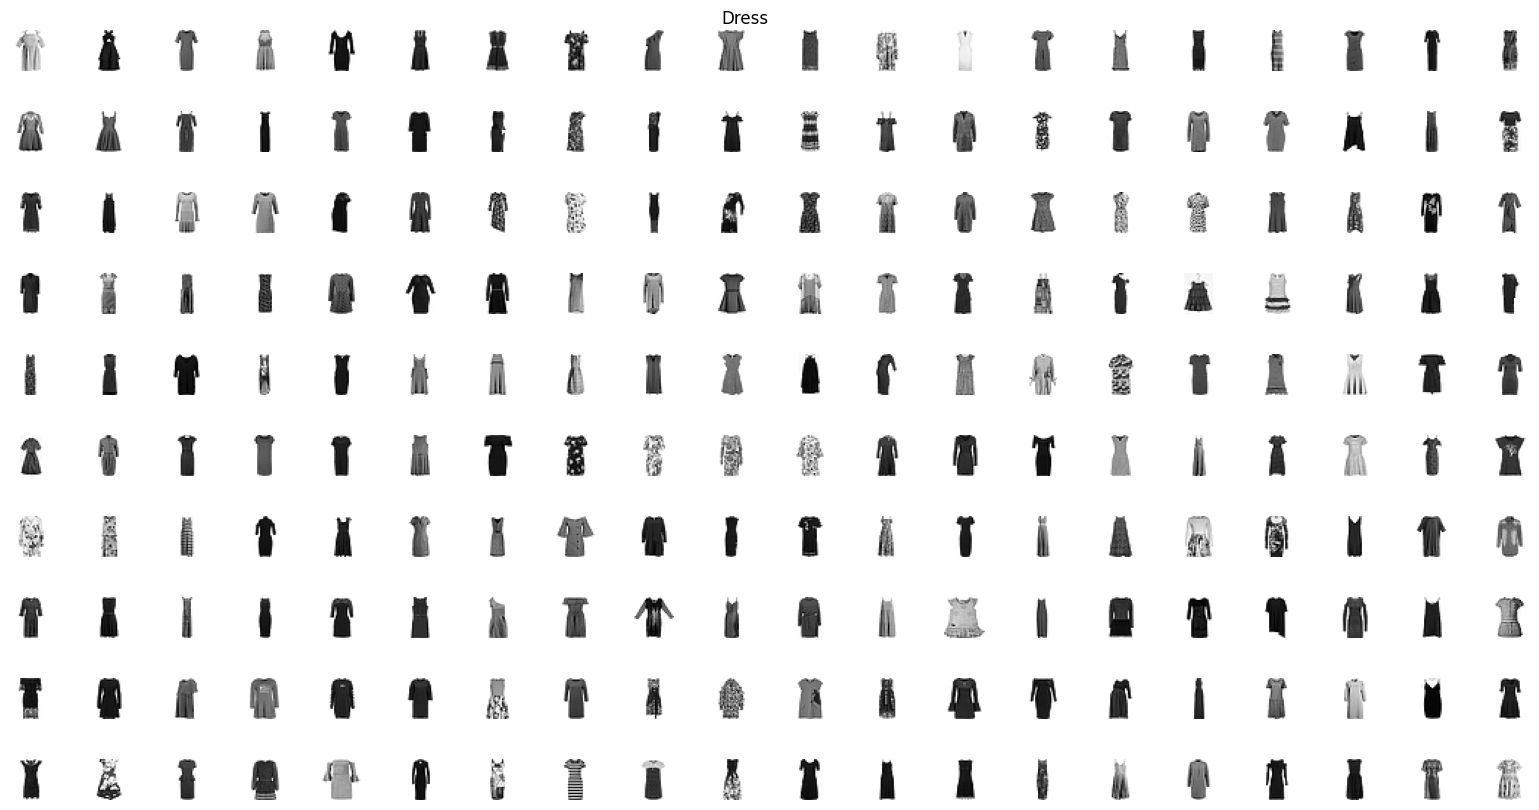

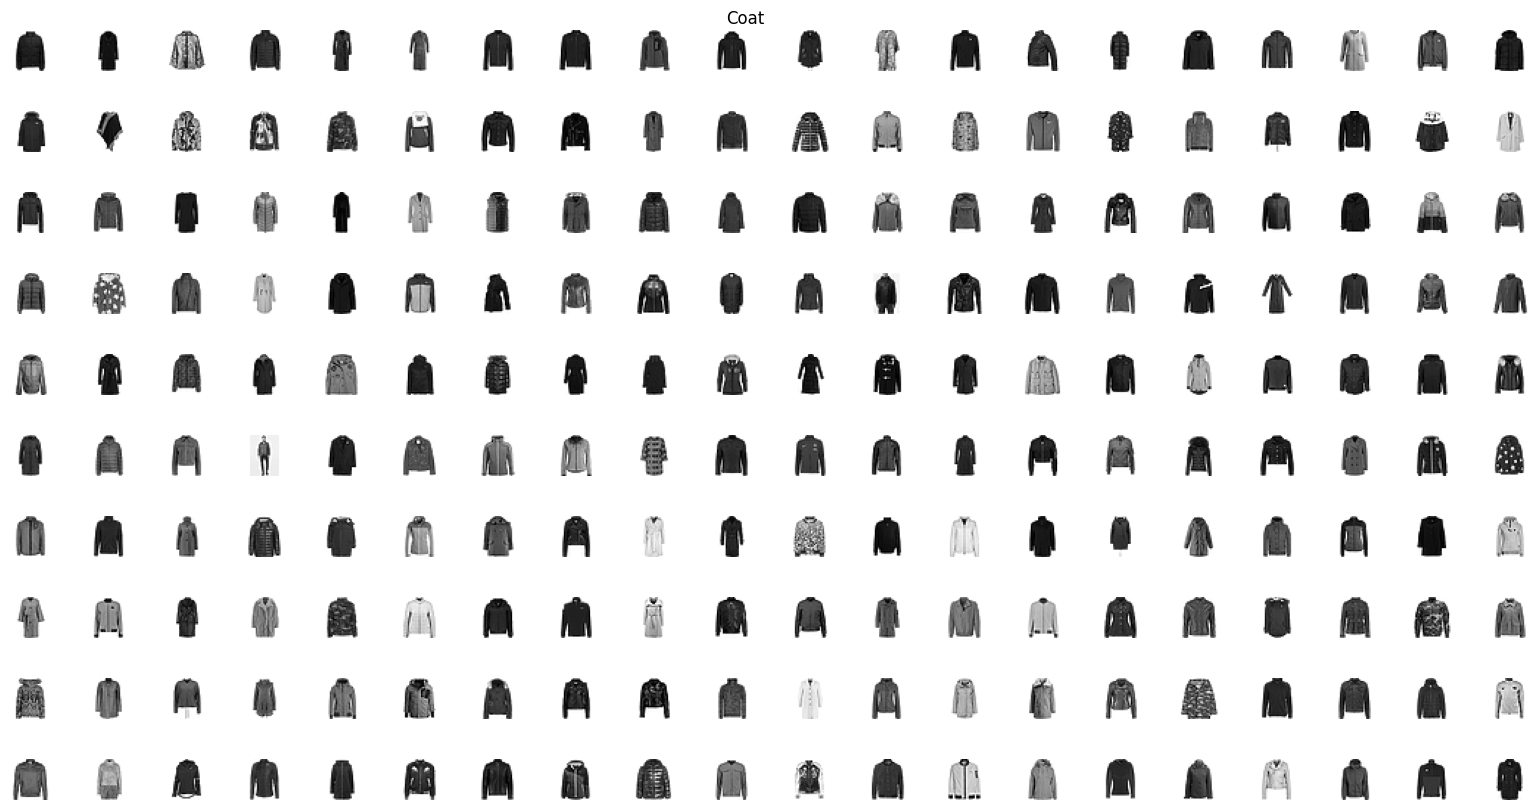

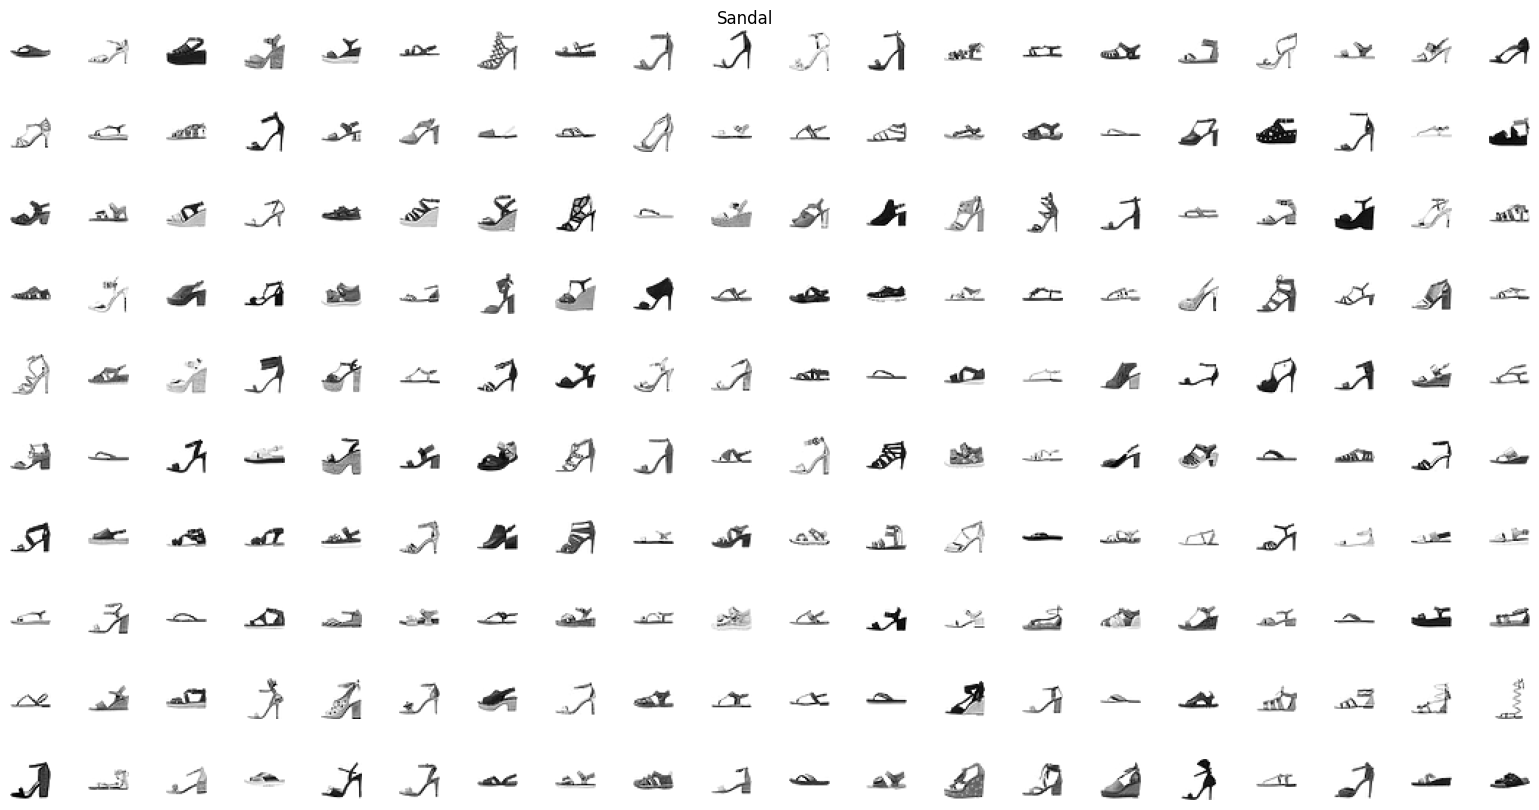

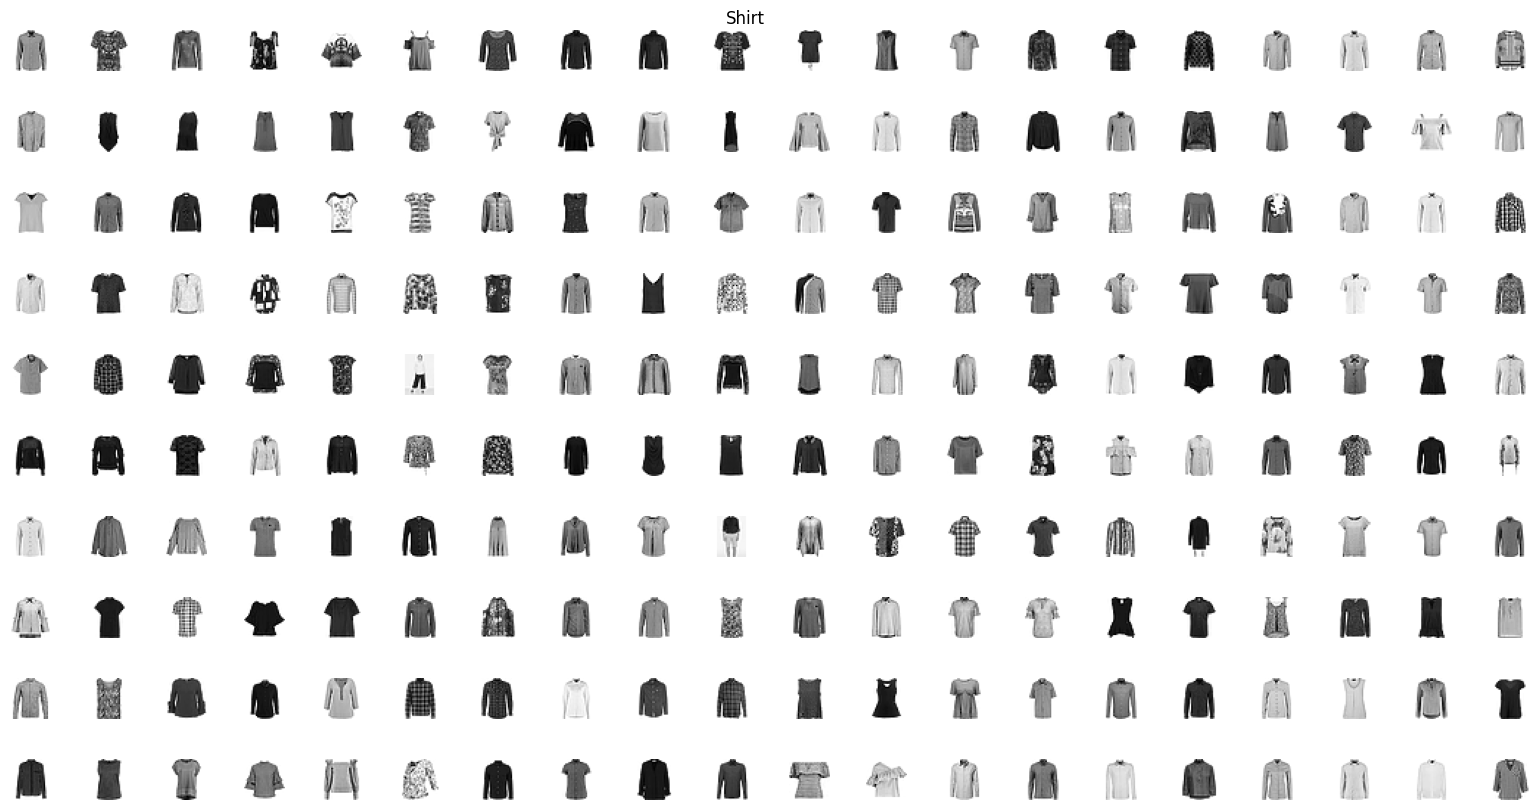

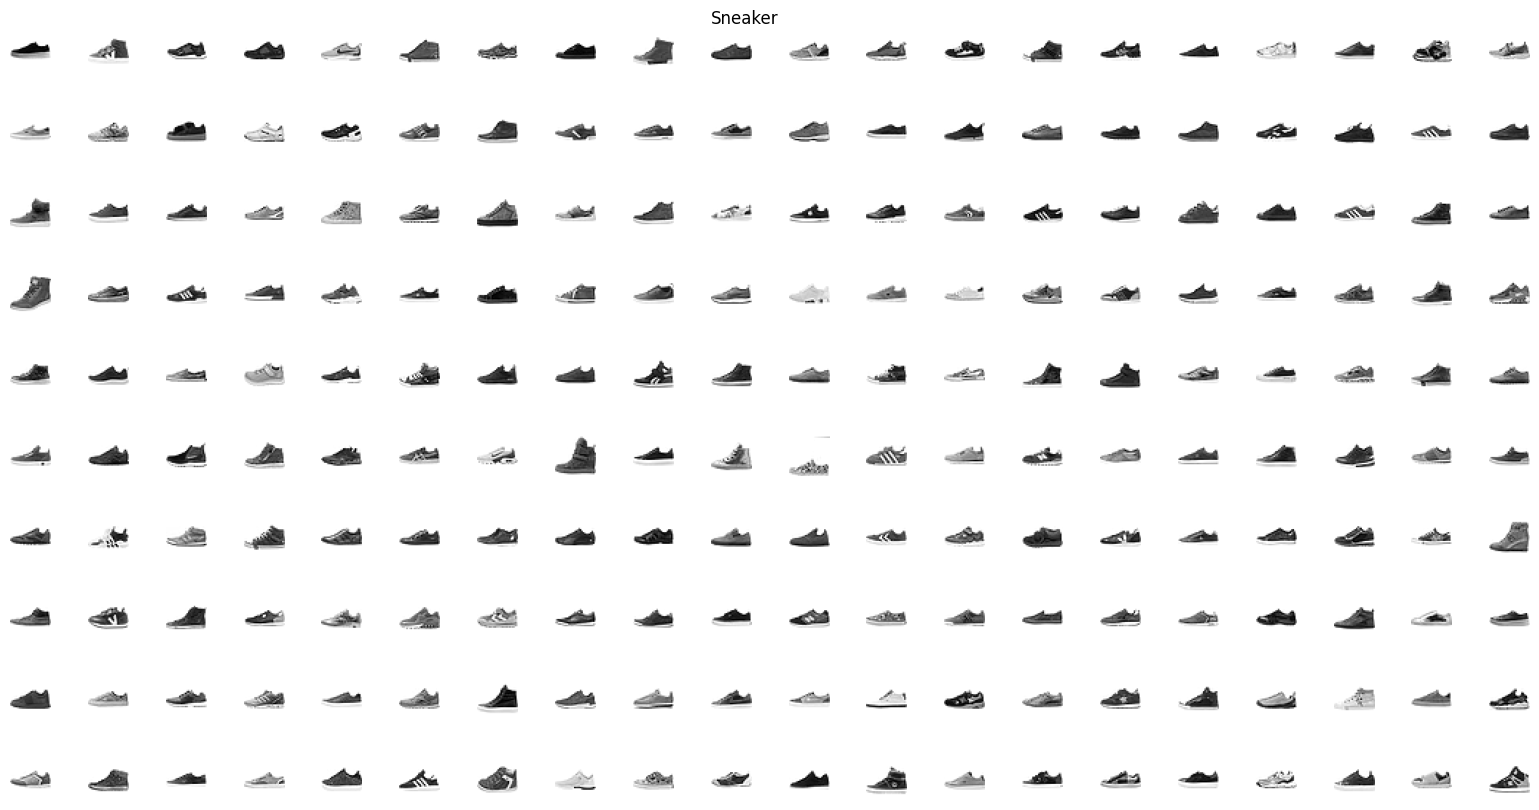

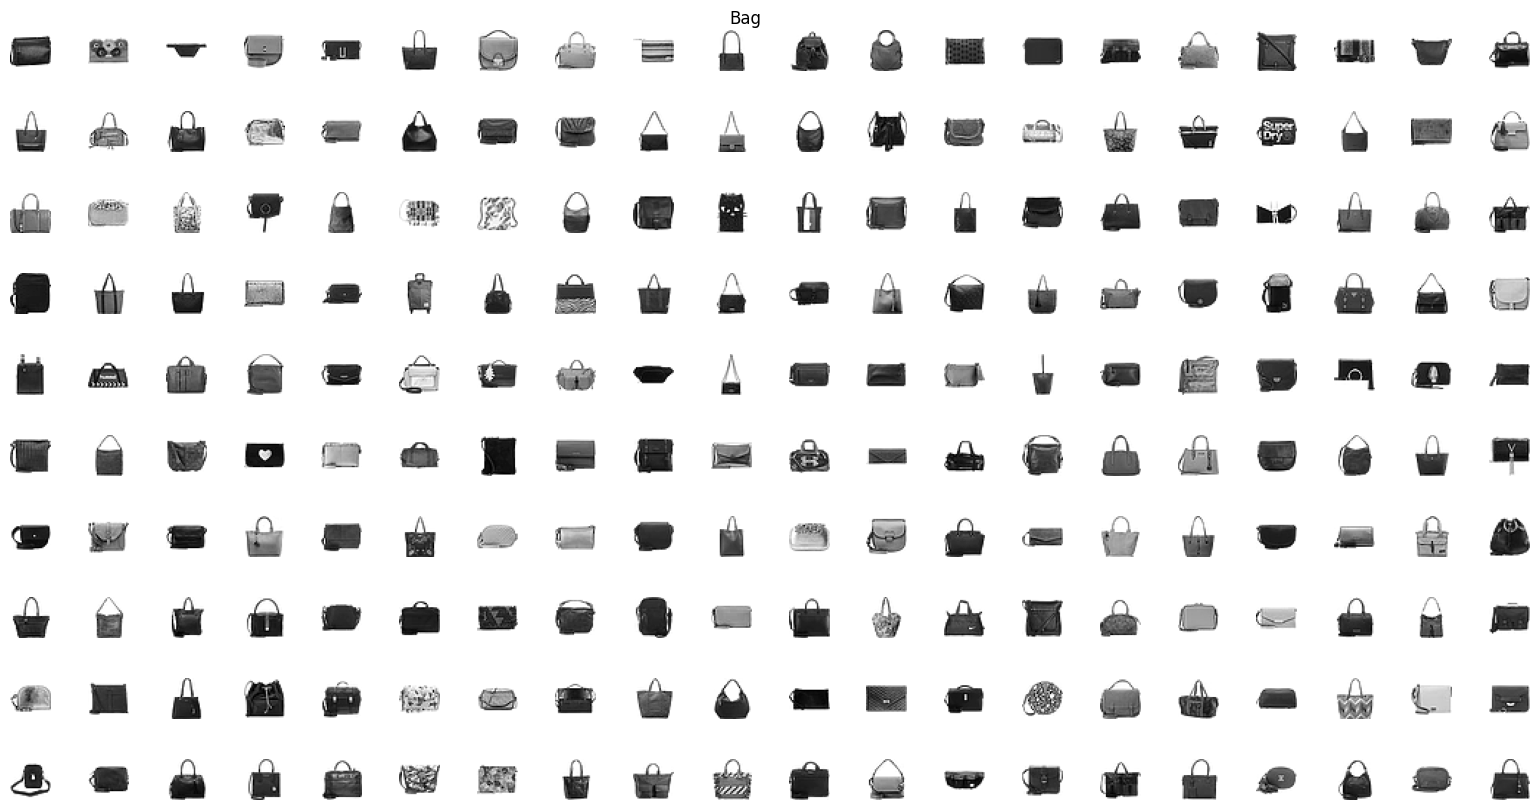

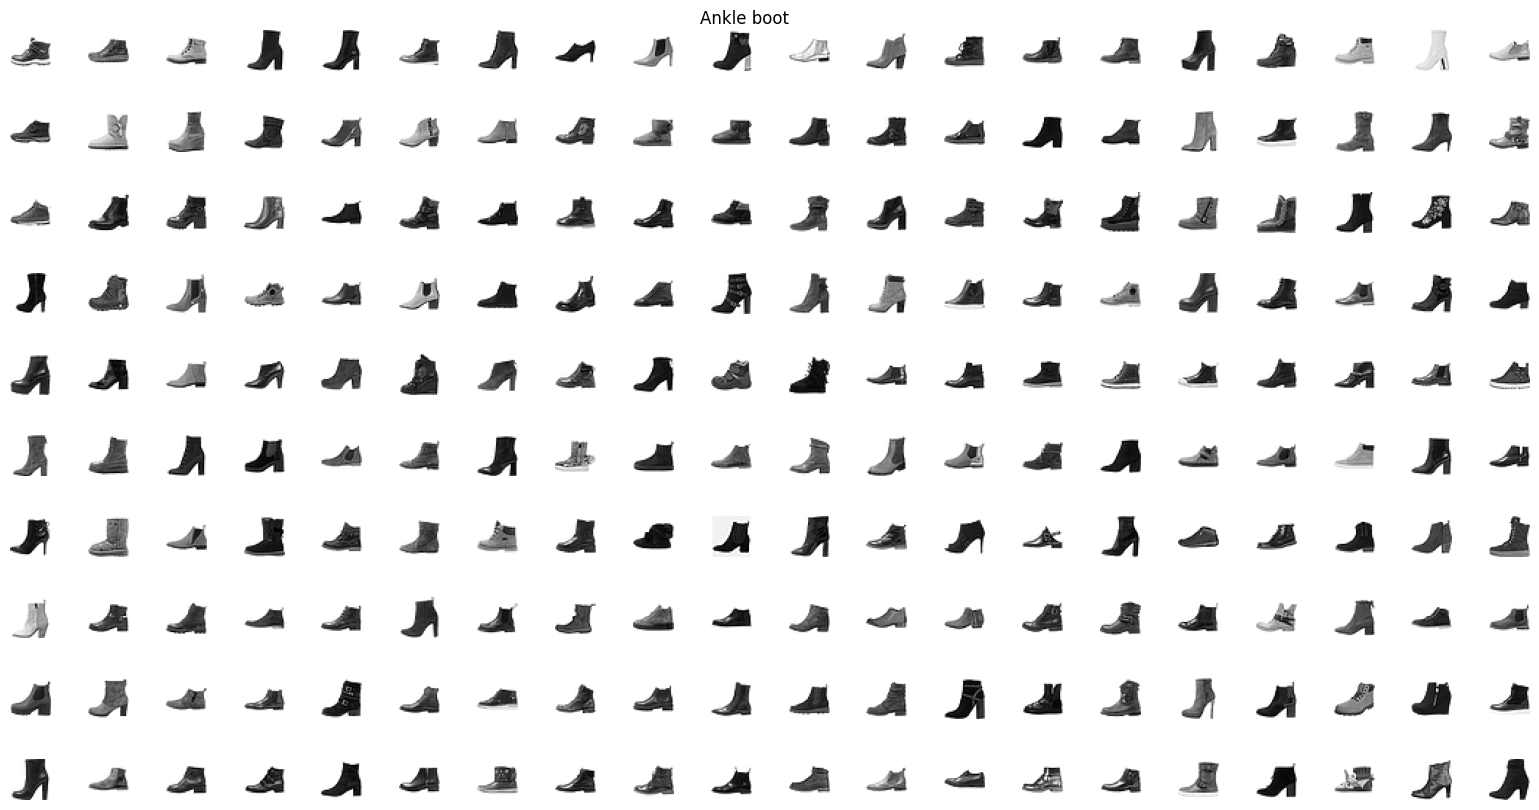

In [6]:
# Let's peek at some digits of each category
for i in range(10):
    show_items(train_input[train_both["label"] == i], 20, 10, label=i)

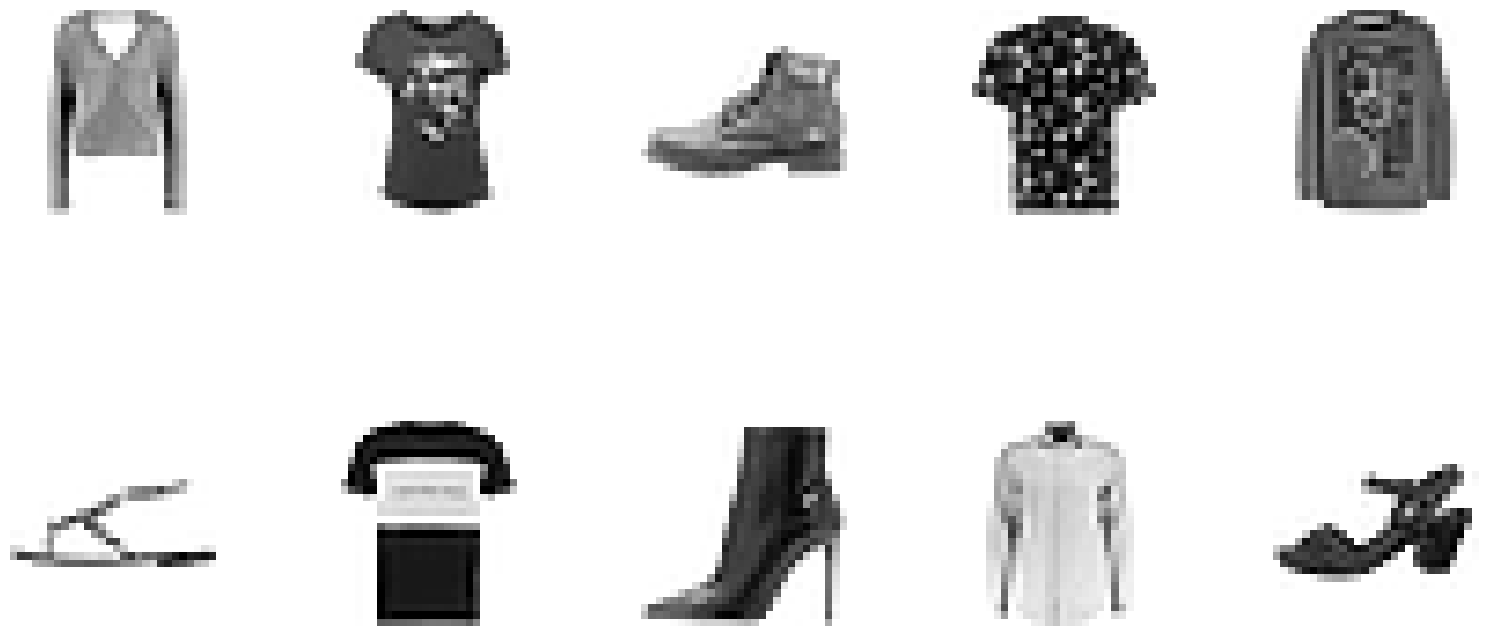

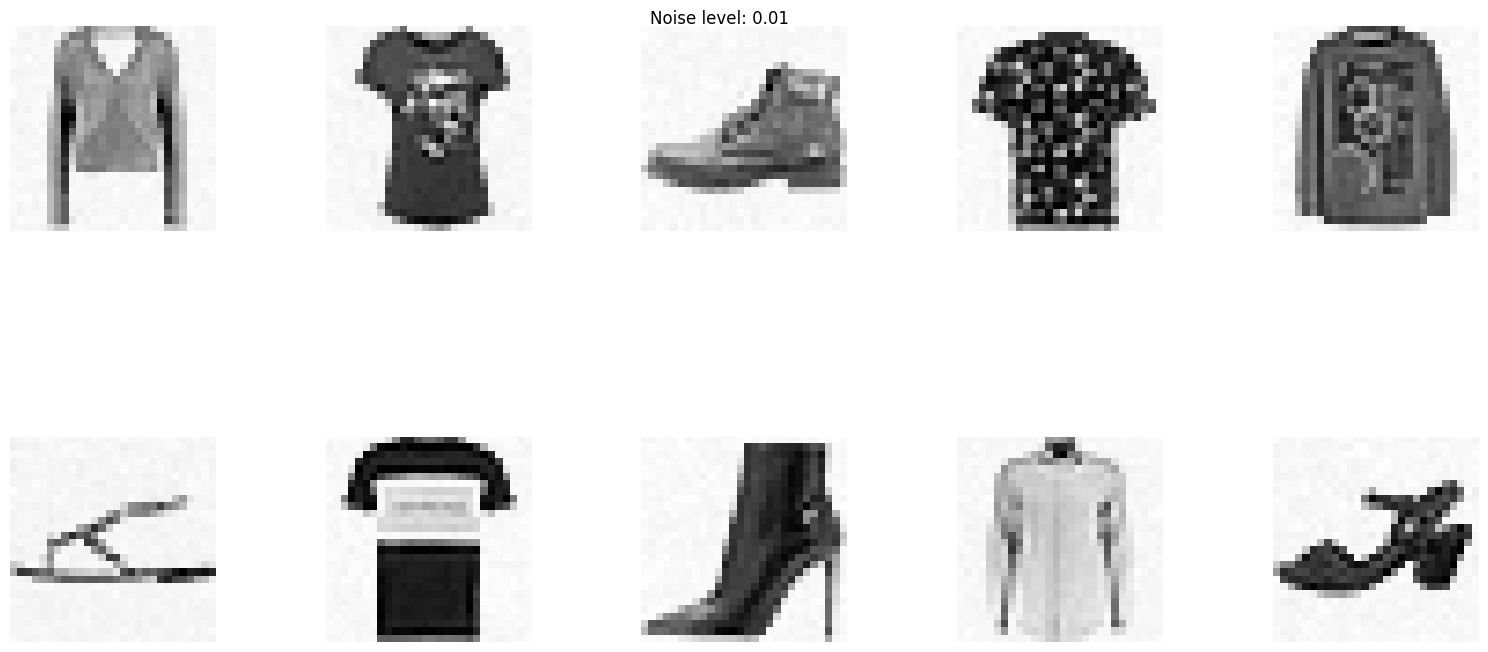

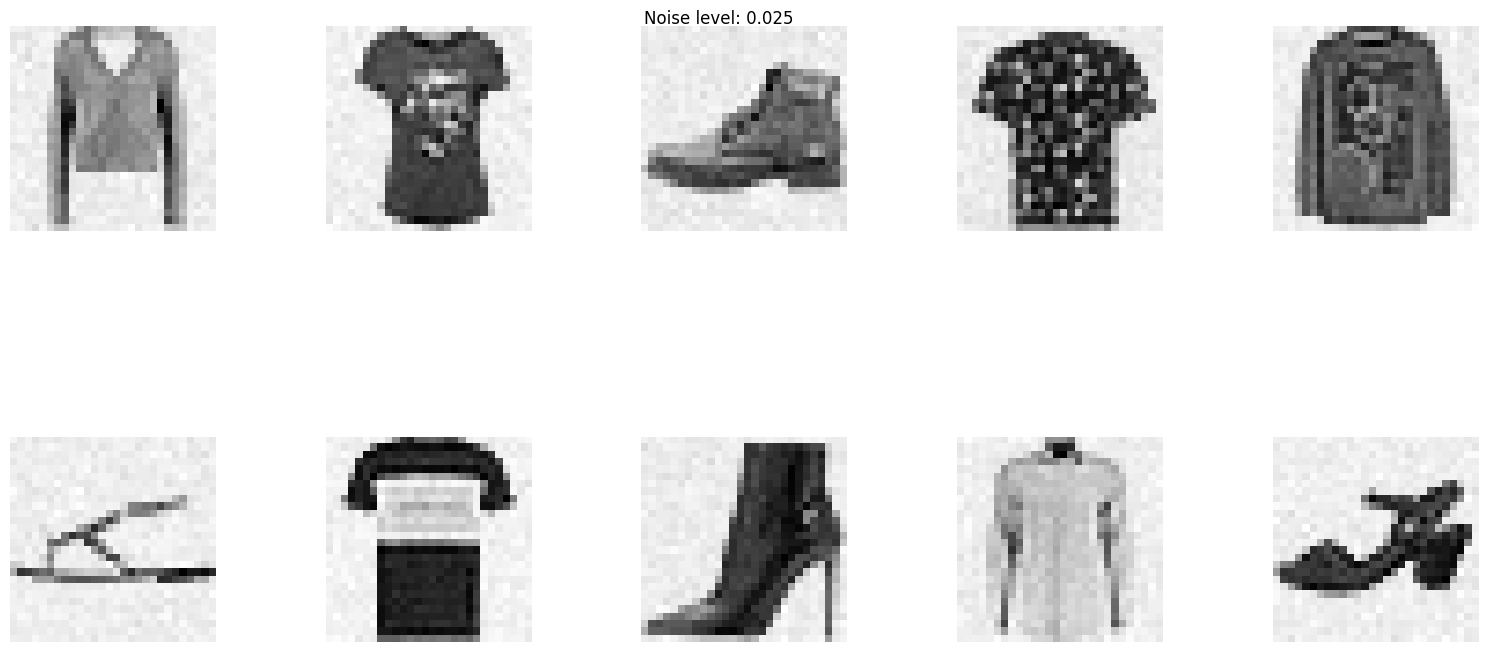

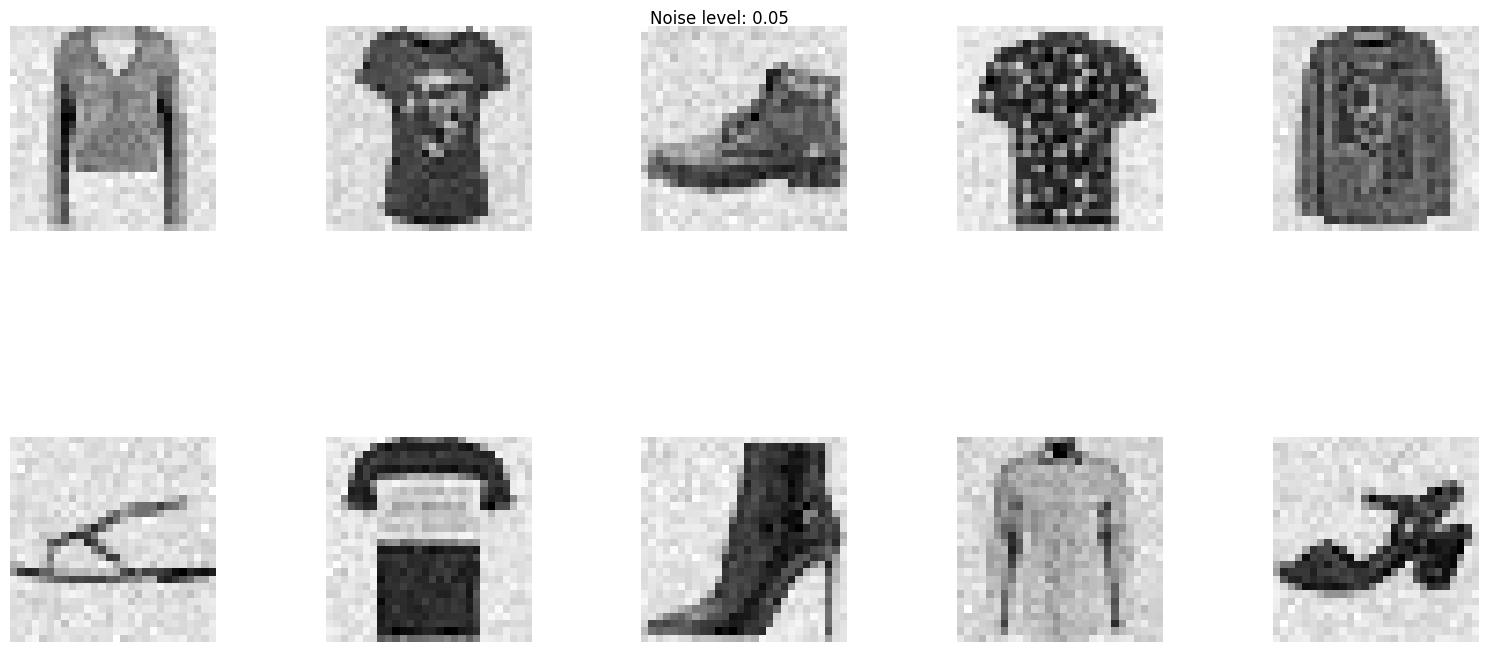

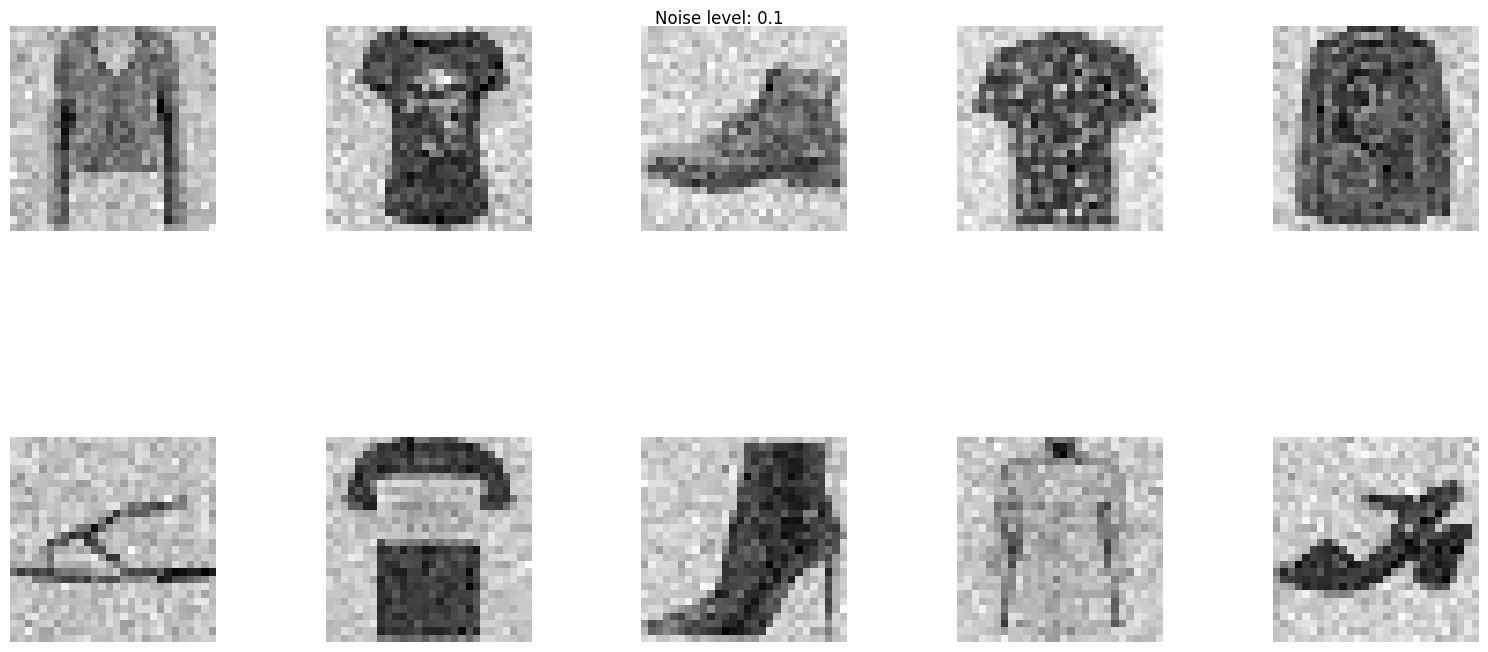

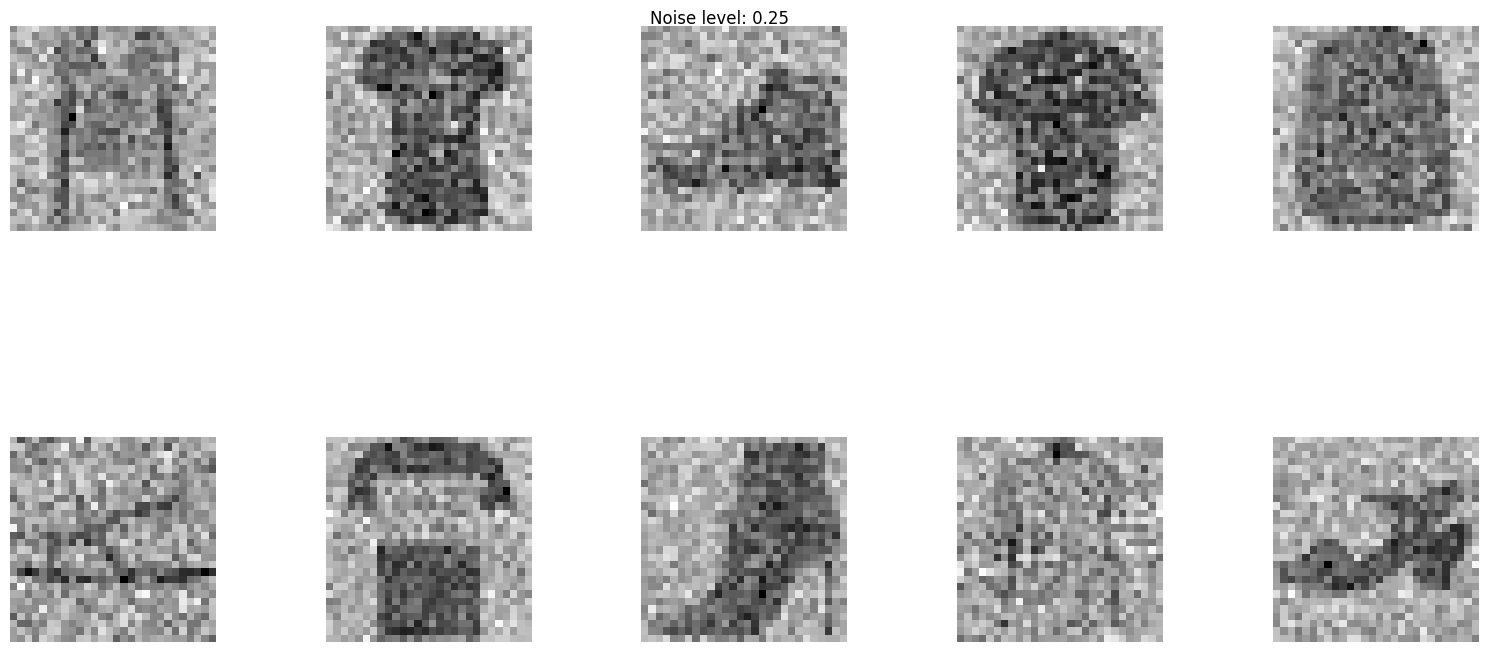

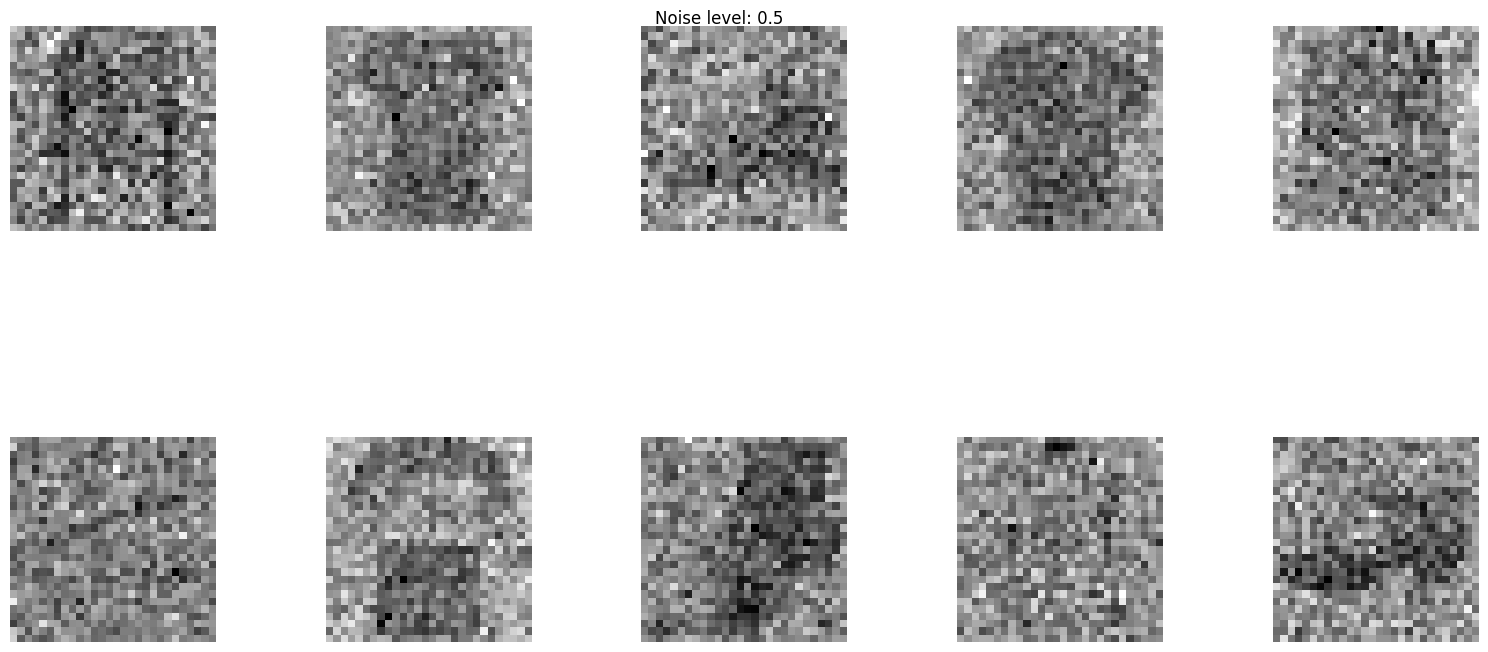

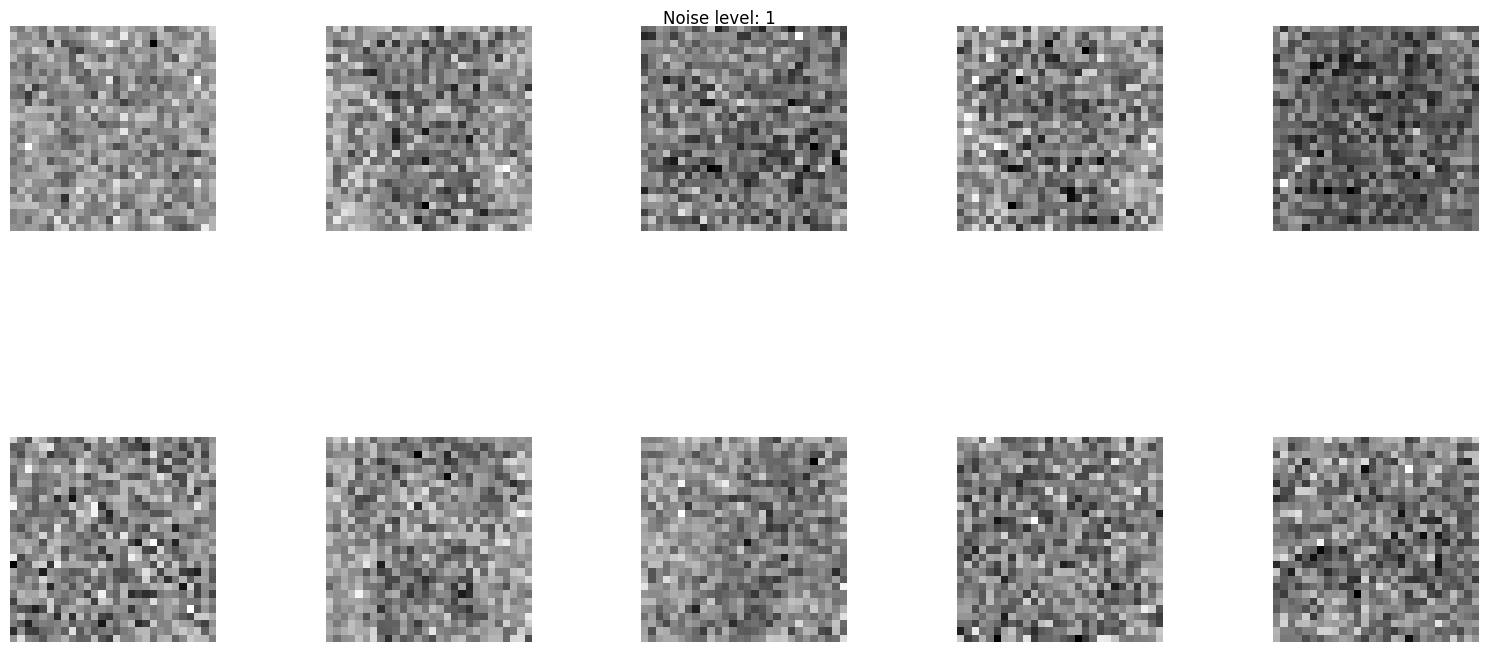

In [7]:
# Problematic instances?
# https://www.kaggle.com/datasets/zalando-research/fashionmnist/discussion/42939
# 1071: reflection of the cloth on the bottom of the image
# 3671: reflection of the cloth on the bottom of the image
# 4382: rotated cloth
# 5184: picture of a model instead of the cloth
# 5705: picture of a model instead of the cloth
# 6491: rotated cloth? one sleeve is missing
# 8812: two cloths in the same picture

bad_instances=[1070,1071,1072,3671,4382,5184,5705,6491,8812,8900]
samples = all_input.loc[bad_instances]

show_items(samples, 5, 2)

# Checking what kind of gaussian noise is too much
for n in [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]:
    noised = samples.copy()
    noise = np.random.normal(0, n, [len(bad_instances),28*28])
    
    noised = noised + noise
    show_items(noised, 5, 2, label="Noise level: %s" % n)

In [8]:
# function to plot the learning curves
def plot_results(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    ax1.plot(history['loss'], label="Train loss")
    if 'val_loss' in history:
        ax1.plot(history['val_loss'], label="Validation loss")
    ax2.plot(history['accuracy'], label="Train accuracy")
    if 'val_accuracy' in history:
        ax2.plot(history['val_accuracy'], label="Validation accuracy")

    ax1.legend(fontsize=15);
    ax2.legend(fontsize=15);

    ax1.set_title('Loss per epoch', fontsize=25);
    ax1.set_xlabel("epoch", fontsize=20);
    ax2.set_title('Accuracy per epoch', fontsize=25);
    ax2.set_xlabel("epoch", fontsize=20);

    ax1.grid(True)
    ax2.grid(True);

In [10]:
# Train a predictor

# Simple feed-forward network
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(784,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

display("FF model summary:")
model.summary()

# A convolution neural network
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), input_shape=[28,28,1], padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="valid"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(10)
])
variability = 0.05
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomRotation((-variability, variability), fill_mode="nearest", interpolation="nearest"),
    tf.keras.layers.RandomTranslation((-variability, variability), (-variability, variability), fill_mode="nearest", interpolation="nearest"),
    tf.keras.layers.RandomZoom((-variability, variability), fill_mode="nearest", interpolation="nearest"),
    tf.keras.layers.RandomContrast(variability),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=[28,28,1], padding="same", activation="relu"),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="valid"),
    tf.keras.layers.GaussianNoise(variability),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="valid"),
    tf.keras.layers.GaussianNoise(variability),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(10)
])

display("CNN model summary:")
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_input, train_labels, epochs=1, validation_data=(challenge_input, challenge_labels))

test_loss, test_acc = model.evaluate(test_input,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

'FF model summary:'

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               100480    
                                                                 
 gaussian_noise_5 (Gaussian  (None, 128)               0         
 Noise)                                                          
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 gaussian_noise_6 (Gaussian  (None, 128)               0         
 Noise)                                               

'CNN model summary:'

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 28, 28, 1)         0         
                                                                 
 random_rotation_1 (RandomR  (None, 28, 28, 1)         0         
 otation)                                                        
                                                                 
 random_translation_1 (Rand  (None, 28, 28, 1)         0         
 omTranslation)                                                  
                                                                 
 random_zoom_1 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 random_contrast_1 (RandomC  (None, 28, 28, 1)        

2023-11-19 20:52:16.145135: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 321753600 exceeds 10% of free system memory.


1604/1604 [==============================] - 21s 12ms/step - loss: 0.6252 - accuracy: 0.7653 - val_loss: 0.4739 - val_accuracy: 0.8163
179/179 - 1s - loss: 0.4843 - accuracy: 0.8112 - 562ms/epoch - 3ms/step

Test accuracy: 0.8112280964851379


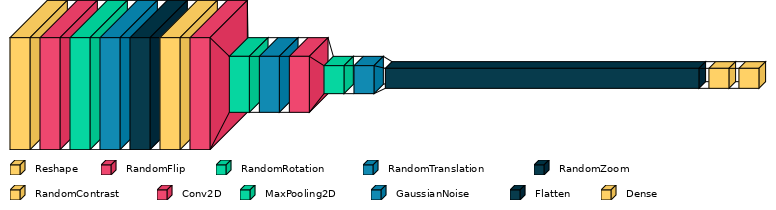

In [12]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 10, encoding="unic")
# A hack to make the legend work because getsize has been removed from Pillow but visualkeras wasn't updated:
# https://github.com/tensorflow/models/issues/11040
font.getsize = lambda str: [8*len(str), 10]

visualkeras.layered_view(model, legend=True, font=font).convert('RGB')

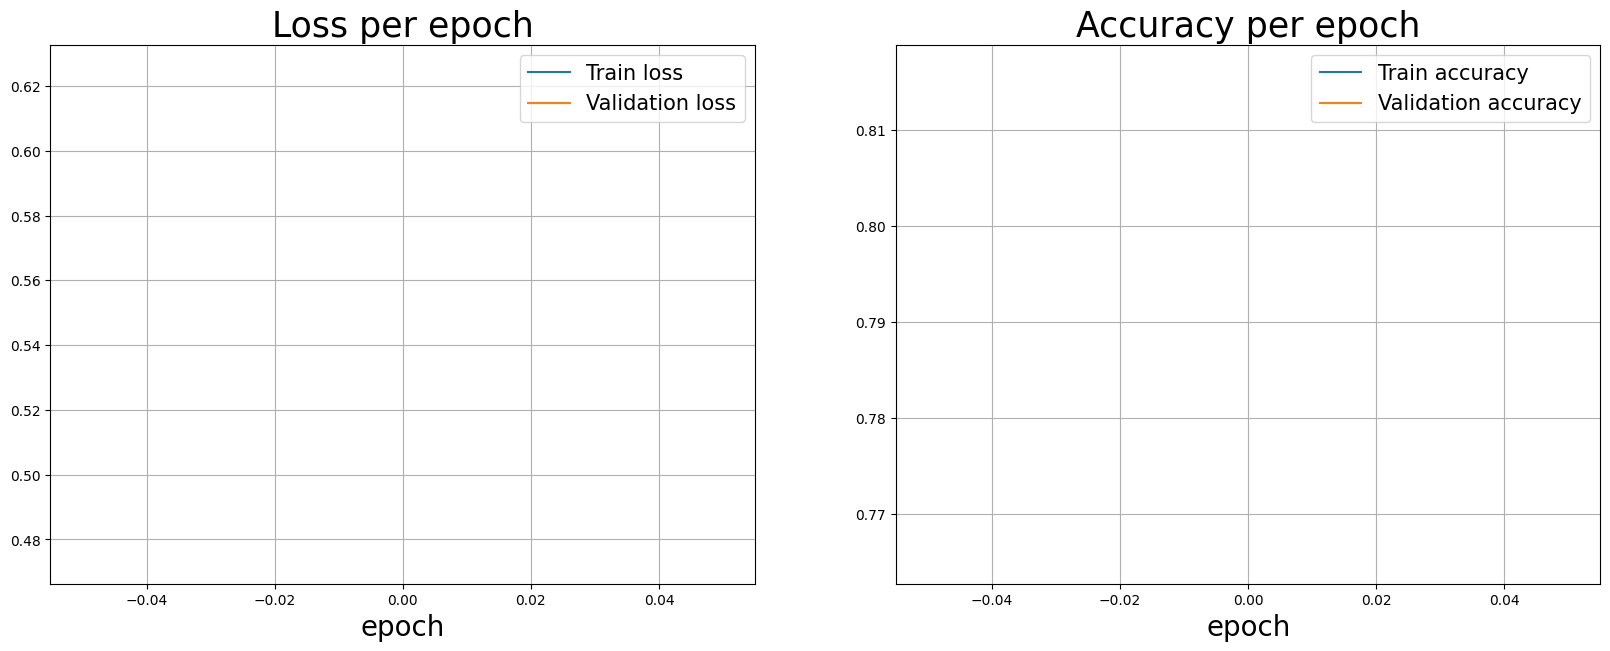

In [13]:
plot_results(history.history)

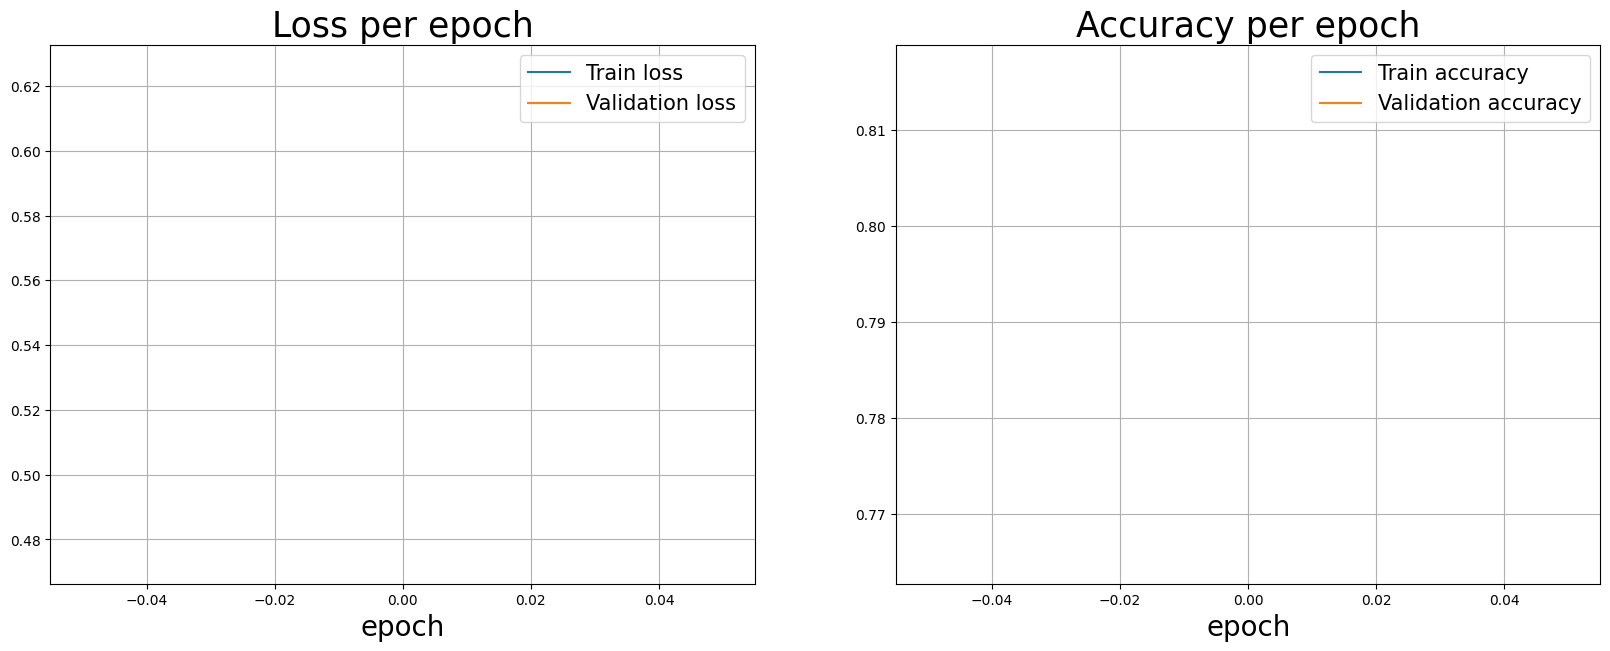

In [14]:
# Variability = 0.1 (except for Gaussian noise = 0.025)
plot_results(history.history)

In [15]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(challenge_input)

challenge_result = challenge_input.copy()
challenge_result["Label"] = np.argmax(predictions, axis=1)
challenge_result["ImageId"] = range(1, len(challenge_result) + 1)
challenge_result.to_csv("cpitrat_tf_result.csv", columns=["ImageId", "Label"], index=False)

313/313 [==============================] - 1s 3ms/step


In [16]:
corrects = pd.DataFrame(challenge_result["Label"] == challenge_labels).rename(columns={0: 'ok'}).groupby("ok").size()
accuracy = 100.0*corrects.loc["True":].iloc[0] / (corrects.loc["True":].iloc[0] + corrects.loc["False":].iloc[0])

print("Accuracy: %s%%" % accuracy)

Accuracy: 81.63%


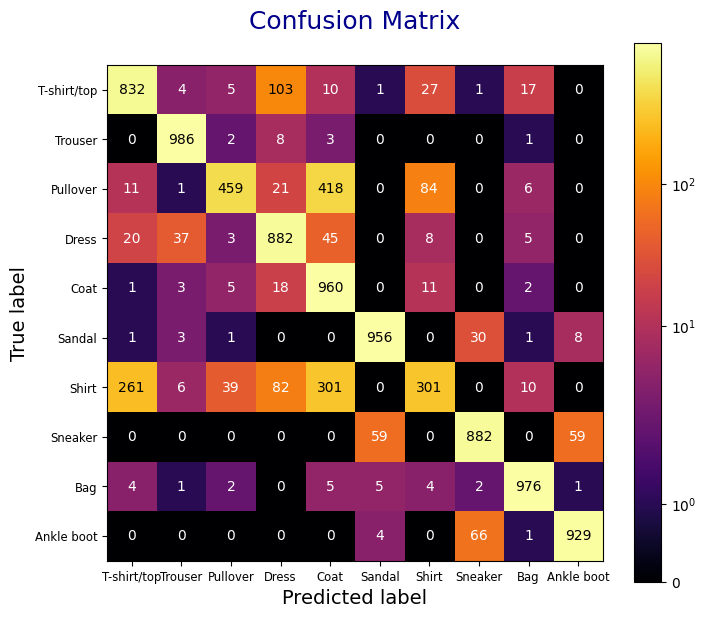

In [17]:
def plot_confusion_matrix(real, predictions, names):
    raw_confusion = tf.math.confusion_matrix(real, predictions)
    # Remove the diagonal
    #confusion = confusion - np.diag(np.diag(confusion))
    
    confusion = pd.DataFrame(
        data=raw_confusion,
        index=names,
        columns=names,
    )
    #display(confusion)
    plt.figure(figsize = (8,7), facecolor='white')
    plt.title('Confusion Matrix\n', fontsize = 18, color = 'darkblue')
    plt.ylabel('True label', fontsize = 14)
    plt.xlabel('Predicted label', fontsize = 14)
    plt.xticks(range(10), labels, size='small')
    plt.yticks(range(10), labels, size='small')
    plt.imshow(confusion, cmap='inferno', norm='symlog')
    for y, row in enumerate(raw_confusion):
        for x, v in enumerate(row):
            color = 'white' if v.numpy() < 100 else 'black'
            plt.text(x, y, v.numpy(), color=color, horizontalalignment='center', verticalalignment='center')
    plt.colorbar(ticks=[0, 1, 10, 100, 1000])
    plt.show()

# -> Predictions
# | Real labels
# V
pd.DataFrame(
    data=tf.math.confusion_matrix(challenge_labels, challenge_result["Label"]),
    index=labels,
    columns=labels,
)
plot_confusion_matrix(challenge_labels, challenge_result["Label"], labels)

In [ ]:
misclassified = challenge_result["Label"] != challenge_labels
misclassified_input = challenge_input[misclassified]
# The true label
misclassified_true_labels = challenge_labels[misclassified]
# The incorrectly predicted label
misclassified_labels = challenge_result[misclassified]["Label"]

show_items(misclassified_input, 10, 55, labels=misclassified_labels.to_numpy(), true_labels=misclassified_true_labels.to_numpy())
